# AIChE 2017 -- *Hands On With Molecular Simulation*

## Part 2 - Managing the Data Space with signac

Part 1 demonstrates the setup and execution of a **single simulation**.
In a more realistic scenario we might want to capture *input* and *output* metadata as well perform a computational investigation over multiple **variables of interest**.

We will now demonstrate how to convert the workflow developed before into one where file and metadata management is handled with [signac].
The **signac framework** is designed to assist large-scale multidimensional computational data generation and analysis. It is assumed that the work can be divided into *projects*, where each project is vaguely confined by roughly similar structured data, *e.g.*, a parameter study.

A *signac project* is the interface to the data space that we will curate for this investigation.
We start by importing the **signac** package and initializing the project.

[Hoomd-Blue]: https://glotzerlab.engin.umich.edu/hoomd-blue
[signac]: http://www.signac.io
[freud]: https://glotzerlab.engin.umich.edu/freud

***The last sentence should come after the below header***

### Data Space Initialization

In [2]:
import signac

project = signac.init_project('AIChE-2017-Hands-On-Example-Project')
print(project)

AIChE-2017-Hands-On-Example-Project


The command above created a configuration file within the current directory, which allows us to get access to the project from any script that is executed within the same directory with `project = signac.get_project()`.

In [3]:
! cat signac.rc

project=AIChE-2017-Hands-On-Example-Project


*(Uncomment and run the cell below to remove all data from previous runs and start over.)*

In [4]:
# for job in project:
#     job.remove()

Let's import some of the other packages required for the execution of this notebook:

In [5]:
import numpy as np
import hoomd
import hoomd.md
import gsd
import gsd.hoomd
from matplotlib import pyplot as plt
%matplotlib inline

hoomd.context.initialize('')

HOOMD-blue v2.2.0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 10/06/2017
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]          Quadro K6000  15 SM_3.5 @ 0.901 GHz, 12204 MiB DRAM, DIS


Next, we define the parameter space that we want to investigate.
We start by identifying the *variable(s) of interest*: any input variable that we want to study the response of.

In this particular case we are going to **vary only the mixing ratio**, but we will also capture some of the most important simulation protocol parameters, such as the temperature, and the *force field* specification.

To initialize the *data space*, we simply iterate over the discretized parameter space, define a full *state point* and call the initialization function:

In [6]:
for concentration_A in (0.25, 0.5, 0.75):
    statepoint = {
        # binary mixture component concentrations
        'mixture': {'A': concentration_A, 'B': 1 - concentration_A},

        # temperature
        'kT': 0.8,

        # force field parameters
        'dpd': [
            {'a': 'A', 'b': 'A', 'A': 10.0, 'gamma': 1.0},
            {'a': 'A', 'b': 'B', 'A': 50.0, 'gamma': 1.0},
            {'a': 'B', 'b': 'B', 'A': 10.0, 'gamma': 1.0},
        ]
    }
    
    # Initialize job for state point
    job = project.open_job(statepoint)
    job.init()

The `job` instance is a handle for a specific *set of parameters* called a *state point*.

We can easily iterate through the complete data space and inspect all of its constituent state points:


In [7]:
from pprint import pprint

for job in project:
    pprint(job.statepoint())
    print()

{'dpd': [{'A': 10.0, 'a': 'A', 'b': 'A', 'gamma': 1.0},
         {'A': 50.0, 'a': 'A', 'b': 'B', 'gamma': 1.0},
         {'A': 10.0, 'a': 'B', 'b': 'B', 'gamma': 1.0}],
 'kT': 0.8,
 'mixture': {'A': 0.75, 'B': 0.25}}

{'dpd': [{'A': 10.0, 'a': 'A', 'b': 'A', 'gamma': 1.0},
         {'A': 50.0, 'a': 'A', 'b': 'B', 'gamma': 1.0},
         {'A': 10.0, 'a': 'B', 'b': 'B', 'gamma': 1.0}],
 'kT': 0.8,
 'mixture': {'A': 0.5, 'B': 0.5}}

{'dpd': [{'A': 10.0, 'a': 'A', 'b': 'A', 'gamma': 1.0},
         {'A': 50.0, 'a': 'A', 'b': 'B', 'gamma': 1.0},
         {'A': 10.0, 'a': 'B', 'b': 'B', 'gamma': 1.0}],
 'kT': 0.8,
 'mixture': {'A': 0.25, 'B': 0.75}}



The *job handle* helps us associate this specific set of parameters and any kind of data by providing us with a specific **job id**:

In [8]:
for job in project:
    print(job.sp.mixture.A, job.get_id())

0.75 5c82b72072da101dff2581c7dbc62c27
0.5 f0aaee8db1242f0851460695d5279d6b
0.25 959d2f61cfe7c757c690272d7c3e7b4f


This *job id* is a unique function of the state point and can be used to associate any kind of data that is a function of the state point, *e.g.*, by using it as part of the file path:
Instead of `c_A_75/init.gsd`, we can use: `5c82b72072da101dff2581c7dbc62c27/init.gsd`.
While this might seem slightly more verbose at first glance, keep in mind that this id does not only encode the *concentration of A*, but also all other parameters which are part of the state point.

File paths like the one above are the *primary storage pattern* with **signac**, which is why the job handle provides functions to easily wrap filenames to produce these kinds of paths:

In [9]:
for job in project:
    print(job.sp.mixture.A, job.fn('init.gsd'))

0.75 /nfs/vizlabhome/vramasub/local/aiche-2017-hands-on/workspace/5c82b72072da101dff2581c7dbc62c27/init.gsd
0.5 /nfs/vizlabhome/vramasub/local/aiche-2017-hands-on/workspace/f0aaee8db1242f0851460695d5279d6b/init.gsd
0.25 /nfs/vizlabhome/vramasub/local/aiche-2017-hands-on/workspace/959d2f61cfe7c757c690272d7c3e7b4f/init.gsd


All operations that modify data associated with that particular set of parameters should be a function of that job handle, files should be stored in the given file paths.

To simplify this process, we are going to combine all steps for the *setup* of the initial configuration into a separate function:

In [10]:
def setup(job):
    np.random.seed(0)
    with hoomd.context.SimulationContext():
        a = 0.6
        unitcell = hoomd.lattice.unitcell(N=4,
                                          a1=(2*a, 0,   0),
                                          a2=(0,   2*a, 0),
                                          a3=(0,   0,   1),
                                          dimensions=2,
                                          position=[(0,0,0), (0,a,0), (a,0,0), (a,a,0)],
                                          type_name=['A', 'B', 'B', 'A'])

        snapshot = unitcell.get_snapshot()
        snapshot.replicate(15, 15, 1)
        
        N_A = int(snapshot.particles.N * job.sp.mixture.A)
        index_array = np.arange(snapshot.particles.N)
        np.random.shuffle(index_array)
        snapshot.particles.typeid[:] = snapshot.particles.types.index('B')
        snapshot.particles.typeid[index_array[:N_A]] = snapshot.particles.types.index('A')

        hoomd.init.read_snapshot(snapshot)
        snapshot.particles.velocity[:,0:2] = np.random.normal(0.0, np.sqrt(0.8 / 1.0), [snapshot.particles.N, 2])
        hoomd.dump.gsd(job.fn('init.gsd'), period=None, group=hoomd.group.all())

We can then simply iterate over the complete data space and call that function:

In [11]:
for job in project:
    setup(job)

notice(2): Group "all" created containing 900 particles
notice(2): Group "all" created containing 900 particles
notice(2): Group "all" created containing 900 particles


An even better approach is to make the function execution conditional on the existence of the `init.gsd` file:

In [12]:
for job in project:
    if not job.isfile('init.gsd'):
        setup(job)

You will notice that the function was not executed this time, because all jobs have already been initialized.

We will also integrate all functions used for carrying out the simulation into a function, by copy & pasting from Part 1:

***Maybe add a link to the previous notebook for Part 1 in case people want to look again***

In [13]:
def simulate(job):
    with hoomd.context.SimulationContext():
        system = hoomd.init.read_gsd('init.gsd', restart='restart.gsd')
        nl = hoomd.md.nlist.cell()
        dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=job.sp.kT, seed=0)
        for ff in job.sp.dpd:
            dpd.pair_coeff.set(**ff)  # We used force field parameter names that match the function parameter names.
        hoomd.md.integrate.mode_standard(dt=0.01)
        hoomd.md.integrate.nve(group=hoomd.group.all())
        hoomd.analyze.log(filename='log-output.log',
              quantities=['potential_energy', 'temperature'],
              period=500)
        hoomd.dump.gsd('trajectory.gsd', period=500, group=hoomd.group.all());
        hoomd.run_upto(5000)
        hoomd.dump.gsd('final.gsd', period=None, group=hoomd.group.all())

Again, all previously hard-coded parameters have been replaced with the respective values that are part of the state point.

You might have noticed that we have not wrapped any of the filenames this time.
That is because we will use a slightly different approach to ensure that all data is read from and stored at the correct location: we just change into the correct *workspace* directory before execution.

***How are you changing into the appropriate directory? Should mention how with clauses work.***

We execute the simulation operation contingent on the existence or non-existence of the corresponding input and output files:

In [14]:
for job in project:
    if job.isfile('init.gsd') and not job.isfile('final.gsd'):
        with job:  # switch into the job's workspace
            simulate(job)
print('Done.')

notice(2): Group "all" created containing 900 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 900
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:08 | Step 5000 / 5000 | TPS 579.106 | ETA 00:00:00
Average TPS: 579.058
---------
-- Neighborlist stats:
797 normal updates / 17 forced updates / 0 dangerous updates
n_neigh_min: 10 / n_neigh_max: 23 / n_neigh_avg: 16.3089
shortest rebuild period: 4
-- Cell list stats:
Dimension: 12, 12, 1
n_min    : 3 / n_max: 10 / n_avg: 6.25
** run complete **
notice(2): Group "all" created containing 900 particles
-----

### Aside: Execution with signac-flow

While it is in principle possible to execute even computationally demanding operations within a jupyter notebook, we recommend using separate scripts for functions such as the one above.

We can utilize the [signac-flow](https://signac-flow.readthedocs.io) package for the execution of high throughput operations locally as well as for scheduling on high-performance clusters.
For the example above, we would simply copy & paste the function into a separate script (*e.g.* `operations.py`) and then augment it with the `flow.run()` interface:
```
# operations.py

def simulate(job):
    with job:
        # [...]
    
if __name__ == '__main__':
    import flow
    flow.run()
```
This would allow us to execute the *simulation* operation directly from the command line with: `$ python operations.py simulate`.

### Analysis

Analysis routines are implemented just as in [part one](Part 1 - Running simulations with HOOMD-blue and analyzing results with Freud.ipynb), however here we can take advantage of **signac**'s search capabilities to examine a specific state point of interest:

We first gather the possible concentrations of *A* and then select the associated jobs using signac's `project.find_jobs()` selection function, displaying plots for each of them.

*The "`for job in project:`" syntax is just short-hand for "`jor job in project.find_jobs()`".*

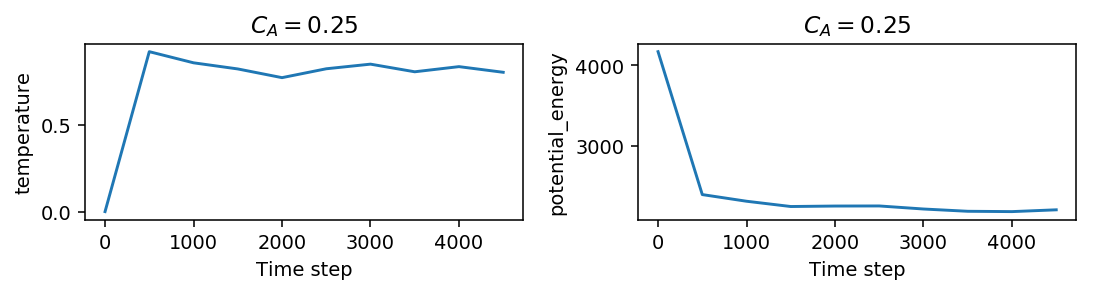

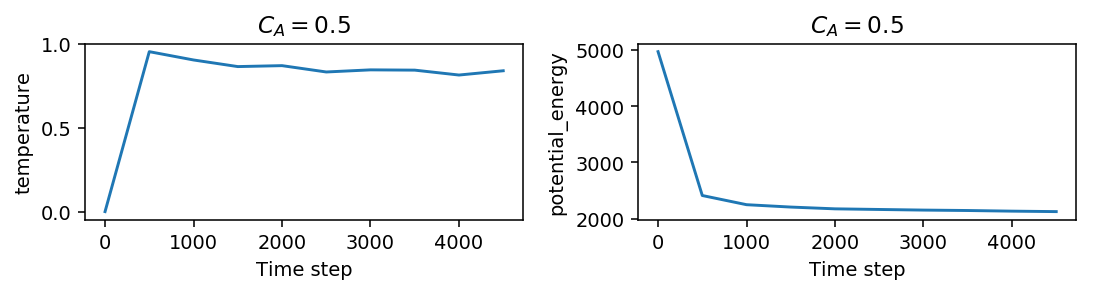

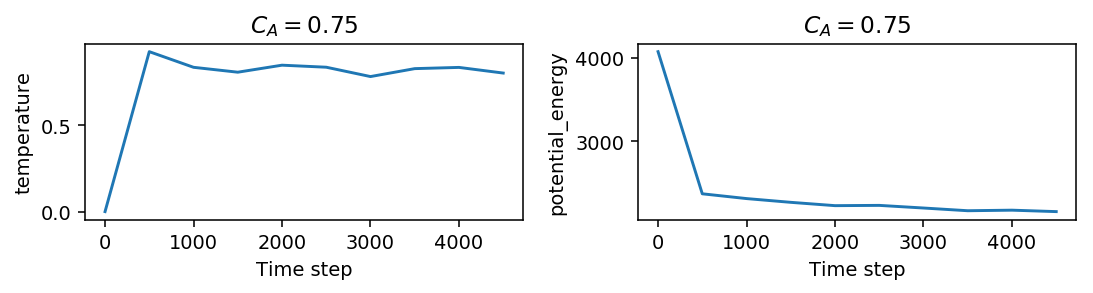

In [15]:
concentrations_A = list(sorted(set([job.sp.mixture.A for job in project])))

for conc_A in concentrations_A:
    jobs = project.find_jobs({'mixture.A': conc_A})
    
    data = [np.genfromtxt(job.fn('log-output.log'), names=True) for job in jobs if job.isfile('log-output.log')]
    time = data[0]['timestep']
    fig, axes = plt.subplots(figsize=(8, 2.2), dpi=140, ncols=2)
    for field, ax in zip(['temperature', 'potential_energy'], axes):
        y = [d[field] for d in data]
        ax.errorbar(time, np.mean(y, axis=0), np.std(y, axis=0))
        ax.set_xlabel('Time step')
        ax.set_ylabel(field)
        ax.set_title('$C_A={}$'.format(conc_A))
    fig.tight_layout()

We can select jobs for the rendering and display the final frame in the same way:

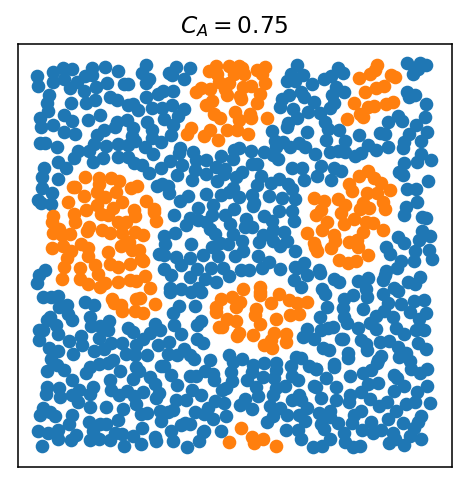

In [16]:
for conc_A in concentrations_A:
    job = list(project.find_jobs({'mixture.A': conc_A}))[0]
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
    with gsd.hoomd.open(job.fn('trajectory.gsd')) as traj:
        frame = traj[-1];
        pos_a = frame.particles.position[frame.particles.typeid==frame.particles.types.index('A'), :]
        pos_b = frame.particles.position[frame.particles.typeid==frame.particles.types.index('B'), :]
        ax.plot(pos_a[:,0], pos_a[:,1], 'o')
        ax.plot(pos_b[:,0], pos_b[:,1], 'o')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('$C_A={}$'.format(conc_A))

### The Job Document

The [job document](http://signac.readthedocs.io/en/latest/projects.html#the-job-document) allows us to store searchable metadata with our job, that is more *dynamic* than the state point.

For example, we might want to select our jobs by the number of clusters in the final frame.
For this, we first implement a routine to compute *the number of clusters over time*, just as in part 1:

***Is the job document really storing just metadata? I often use it for actual data as well. I might rephrase as "The job document allows us to store both data and metadata that is more dynamic than the metadata stored in the state point"***

In [17]:
import freud

def compute_clusters(job, species):
    step = []
    n_clusters = []

    with gsd.hoomd.open(job.fn('trajectory.gsd')) as traj:
        for frame in traj[1:]:
            box = freud.box.Box(Lx=frame.configuration.box[0], Ly=frame.configuration.box[1], is2D=True)
            cluster = freud.cluster.Cluster(box, 1.0)
            pos_b = frame.particles.position[frame.particles.typeid==frame.particles.types.index(species), :]
            cluster.computeClusters(pos_b)

            step.append(frame.configuration.step)
            n_clusters.append(cluster.getNumClusters())
    return n_clusters

Then we iterate over all jobs, and store the final number of clusters in the job document:

In [18]:
for job in project:
    if job.isfile('trajectory.gsd'):
        clusters = {species: compute_clusters(job, species)[-1] for species in ('A', 'B')}
        job.document['n_clusters_final'] = clusters
        print(job, clusters)

5c82b72072da101dff2581c7dbc62c27 {'A': 1, 'B': 5}
f0aaee8db1242f0851460695d5279d6b {'A': 1, 'B': 1}
959d2f61cfe7c757c690272d7c3e7b4f {'A': 9, 'B': 1}


Just like we can use a *filter* to select jobs by state point values, we can use a *docfilter* to select jobs by document values.

Here we show all jobs, where the number of *B* clusters in the final frame is greater than one:

In [19]:
for job in project.find_jobs(doc_filter={'clusters.B': {'$gt': 1}}):
    print('mix', job.sp.mixture, 'n_clusters_final', job.document['n_clusters_final'])

### Data space modification

A common requirement is the need to **modify the data space** after the fact.
For example, we might be satisfied with the preliminary results generated above, but might want to add some replication to determine the statistical uncertainty.

For this we are going to vary the *random seed* and make it an explicit part of our state point.
First, we need to **migrate** the existing jobs to add the random seed explicitly to the state point:

In [20]:
# Migrate existing jobs and remove duplicates
for job in project:
    if 'seed' not in job.sp:
        try:
            job.sp.seed = 0
        except signac.errors.DestinationExistsError:
            job.remove()

We could modify and execute the initialization loop from above again, but instead we are going to copy the existing job statepoints and initialize copies with different random seeds.

In [21]:
for job in project:
    sp = job.statepoint()
    for seed in 0, 1:
        sp['seed'] = seed
        project.open_job(sp).init()
        
for job in project:
    print(job, job.sp.mixture.A, job.sp.seed)

13d97eb0d0c5daaad4b5aa209de1d93f 0.25 1
967b282ef823a534b583ec49a6bd46ee 0.5 1
40cad0e5f0d99d3d153c860ec98f52cd 0.75 1
7187306062fe35b840d747a146d31e8c 0.25 0
103c6ce965195a2a1b86cf5a75de1ece 0.5 0
4fe1c9fbecf4e3f40017e99e7e4e4a88 0.75 0


Then we update our operations from above to replace the previously hard-coded random seed with the one from the state point:

In [22]:
def setup(job):
    # ################################### #
    #                                     #
    # REPLACED HARD-CODED RANDOM SEED HERE:
    np.random.seed(job.sp.seed)
    
    with hoomd.context.SimulationContext():
        a = 0.6
        unitcell = hoomd.lattice.unitcell(N=4,
                                          a1=(2*a, 0,   0),
                                          a2=(0,   2*a, 0),
                                          a3=(0,   0,   1),
                                          dimensions=2,
                                          position=[(0,0,0), (0,a,0), (a,0,0), (a,a,0)],
                                          type_name=['A', 'B', 'B', 'A'])

        snapshot = unitcell.get_snapshot()
        snapshot.replicate(15, 15, 1)
        
        N_A = int(snapshot.particles.N * job.sp.mixture.A)
        index_array = np.arange(snapshot.particles.N)
        np.random.shuffle(index_array)
        snapshot.particles.typeid[:] = snapshot.particles.types.index('B')
        snapshot.particles.typeid[index_array[:N_A]] = snapshot.particles.types.index('A')

        hoomd.init.read_snapshot(snapshot)
        snapshot.particles.velocity[:,0:2] = np.random.normal(0.0, np.sqrt(0.8 / 1.0), [snapshot.particles.N, 2])
        hoomd.dump.gsd(job.fn('init.gsd'), period=None, group=hoomd.group.all())
        
def simulate(job):
    with hoomd.context.SimulationContext():
        system = hoomd.init.read_gsd('init.gsd', restart='restart.gsd')
        nl = hoomd.md.nlist.cell()
        # ################################### #
        #                                     #
        # REPLACED HARD-CODED RANDOM SEED HERE:
        dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=job.sp.kT, seed=job.sp.seed)
        for ff in job.sp.dpd:
            dpd.pair_coeff.set(**ff)  # We used force field parameter names that match the function parameter names.
        hoomd.md.integrate.mode_standard(dt=0.01)
        hoomd.md.integrate.nve(group=hoomd.group.all())
        hoomd.analyze.log(filename='log-output.log',
              quantities=['potential_energy', 'temperature'],
              period=500)
        hoomd.dump.gsd('trajectory.gsd', period=500, group=hoomd.group.all());
        hoomd.run_upto(5000)
        hoomd.dump.gsd('final.gsd', period=None, group=hoomd.group.all())

Let's execute the complete workflow within one cell:

In [23]:
for job in project:
    print(job)
    if not job.isfile('init.gsd'):
        setup(job)
    if job.isfile('init.gsd') and not job.isfile('final.gsd'):
        with job:  # switch into the job's workspace
            simulate(job)
print('Done.')

13d97eb0d0c5daaad4b5aa209de1d93f
notice(2): Group "all" created containing 900 particles
notice(2): Group "all" created containing 900 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 900
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:08 | Step 5000 / 5000 | TPS 616.236 | ETA 00:00:00
Average TPS: 616.179
---------
-- Neighborlist stats:
795 normal updates / 17 forced updates / 0 dangerous updates
n_neigh_min: 10 / n_neigh_max: 23 / n_neigh_avg: 16.2422
shortest rebuild period: 4
-- Cell list stats:
Dimension: 12, 12, 1
n_min    : 3 / n_max: 12 / n_a

Now run the analysis section again, to visualize the statistical certainty!

## Exercises

### 1. Store rendered snapshot images

Store an image of the last snapshot in a file called `snapshot.png` in each job's workspace.

Hint: Use matplotlib's `savefig()` function.

### 2. Cached cluster analysis

Implement a function `get_clusters(job, species)` that returns the number of clusters for all time steps by loading them from the job document or calculating them in case that they have not been stored yet ([memoization]).

### 3. Highest cluster density for A/B

Find the two concentrations that result in either the highest number of A cluster or the highest number of B clusters.

### Bonus: Remove code duplication

Modify the notebook to account for the seed variable without code duplication:

1. Add the random seed directly to the initialization loop:
```
for concentration_A in (0.25, 0.5, 0.75):
        for seed in (0, 1):
                statepoint = {
                     'seed': seed,
                # ...
                }   
# Initialize job for state point
job = project.open_job(statepoint).init()
```
2. Replace the original `setup()` routine to use the correct random seed and remove the duplicate.
3. Replace the original `simulate()` routine to use the correct random seed and remove the duplicate.
4. Combine the different *operation execution cells* into a single cell.

**A robust notebook implementation should essentially be [reentrant].**

[Link to the proposed solutions.](Part 2 - Proposed Solutions.ipynb)

[memoization]: https://en.wikipedia.org/wiki/Memoization
[reentrant]: https://en.wikipedia.org/wiki/Reentrancy_(computing)